# Author Information

**Author:** CHUA JINGXUAN

**Taylor's Student ID:** 0365376

**Email:** 0365376@sd.taylors.edu.my

**Note:** This Jupyter Notebook was written by CHUA JINGXUAN. If you find any issues, have questions, or want to provide feedback, please don't hesitate to reach out. Thank you for exploring this notebook!

**Date Written**: 28/07/2024 (MON)

**Last Updated**: 30/07/2024 (TUE)

---
# ITS70804 Text and Image Processing: ASSIGNMENT 3
---

# Trial 05: VGG16 (Teacher) + DeiT-Tiny (Student)

# Importing Essential Libraries

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torchvision.models as models
import timm
import time
from sklearn.metrics import classification_report, accuracy_score

C:\Users\Chris\.conda\envs\torch_con\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1.0 Data Loading and Apply Augmentation

In [ ]:
from torch.utils.data.dataset import random_split

def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images for DeiT input
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),  # Normalize for CIFAR-10
    ])

# Loading CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=get_transforms())
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Get the test dataset
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=get_transforms())

# Split the test dataset into validation and test datasets
val_size = len(test_dataset) // 2  # Half of the test dataset
test_size = len(test_dataset) - val_size

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Create the validation and test loaders
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# 2.0 Instantiate Teacher and Student Model

In [ ]:
# Initialize the teacher model (VGG16)
teacher_model = models.vgg16(pretrained=True)
teacher_model.classifier[-1] = nn.Linear(teacher_model.classifier[-1].in_features, 10)  # Adjusting the final layer for CIFAR-10
teacher_model = teacher_model.eval()  # Set to evaluation mode

# Initialize the student model (DeiT Tiny)
student_model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=10)
student_model.train()

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = teacher_model.to(device)
student_model = student_model.to(device)

# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters
teacher_params = count_parameters(teacher_model)
student_params = count_parameters(student_model)
print(f"Number of parameters in teacher model (VGG16): {teacher_params}")
print(f"Number of parameters in student model (DeiT Tiny): {student_params}")

C:\Users\Chris\.conda\envs\torch_con\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Chris\.conda\envs\torch_con\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Chris/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [01:43<00:00, 5.34MB/s]


Number of parameters in teacher model (VGG16): 134301514
Number of parameters in student model (DeiT Tiny): 5526346


# 3.0 Define Loss Function and Optimizer

In [ ]:
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.0005)  # Smaller learning rate for fine-tuning

def distillation_loss(student_output, teacher_output, labels, T=3.0):
    soft_loss = F.kl_div(F.log_softmax(student_output/T, dim=1), F.softmax(teacher_output/T, dim=1), reduction='batchmean')
    hard_loss = F.cross_entropy(student_output, labels)
    return soft_loss + hard_loss

temperature = 3.0  # Temperature for softening probabilities

# 4.0 Model Training Loop and Timing

In [ ]:
# Number of epochs
num_epochs = 50

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training and validation loop
for epoch in range(num_epochs):
    student_model.train()  # Set the student model to training mode
    total_loss = 0
    train_correct = 0
    train_total = 0
    start_time = time.time()  # Start timing the epoch

    # Training loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass through teacher model
        with torch.no_grad():
            teacher_outputs = teacher_model(images)

        # Forward pass through student model
        student_outputs = student_model(images)

        # Compute loss
        loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature)
        optimizer.zero_grad()  # Clear gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update parameters

        # Accumulate loss and accuracy
        total_loss += loss.item()
        _, predicted = torch.max(student_outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate training metrics
    epoch_duration = time.time() - start_time
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = (train_correct / train_total) * 100
    train_accuracies.append(train_accuracy)

    # Validation loop
    student_model.eval()  # Set the student model to evaluation mode
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            teacher_outputs = teacher_model(images)  # Also generate teacher outputs for validation
            outputs = student_model(images)
            batch_loss = distillation_loss(outputs, teacher_outputs, labels, temperature)
            val_loss += batch_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate validation metrics
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = (val_correct / val_total) * 100
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds')

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1/50, Loss: 1.9061, Accuracy: 36.90%, Duration: 293.04 seconds
Epoch 2/50, Loss: 1.6312, Accuracy: 44.19%, Duration: 295.89 seconds
Epoch 3/50, Loss: 1.4866, Accuracy: 49.15%, Duration: 295.11 seconds
Epoch 4/50, Loss: 1.3842, Accuracy: 52.98%, Duration: 294.96 seconds
Epoch 5/50, Loss: 1.2967, Accuracy: 54.30%, Duration: 295.08 seconds
Epoch 6/50, Loss: 1.2173, Accuracy: 56.98%, Duration: 295.00 seconds
Epoch 7/50, Loss: 1.1484, Accuracy: 61.09%, Duration: 291.31 seconds
Epoch 8/50, Loss: 1.0803, Accuracy: 61.78%, Duration: 295.44 seconds
Epoch 9/50, Loss: 1.0247, Accuracy: 64.19%, Duration: 296.98 seconds
Epoch 10/50, Loss: 0.9789, Accuracy: 64.93%, Duration: 298.47 seconds
Epoch 11/50, Loss: 0.9455, Accuracy: 65.94%, Duration: 298.36 seconds
Epoch 12/50, Loss: 0.9014, Accuracy: 66.21%, Duration: 294.41 seconds
Epoch 13/50, Loss: 0.8742, Accuracy: 69.04%, Duration: 295.70 seconds
Epoch 14/50, Loss: 0.8455, Accuracy: 69.63%, Duration: 299.05 seconds
Epoch 15/50, Loss: 0.8109, Ac

In [ ]:
torch.save(student_model.state_dict(), './vgg16_deit_student.pth')

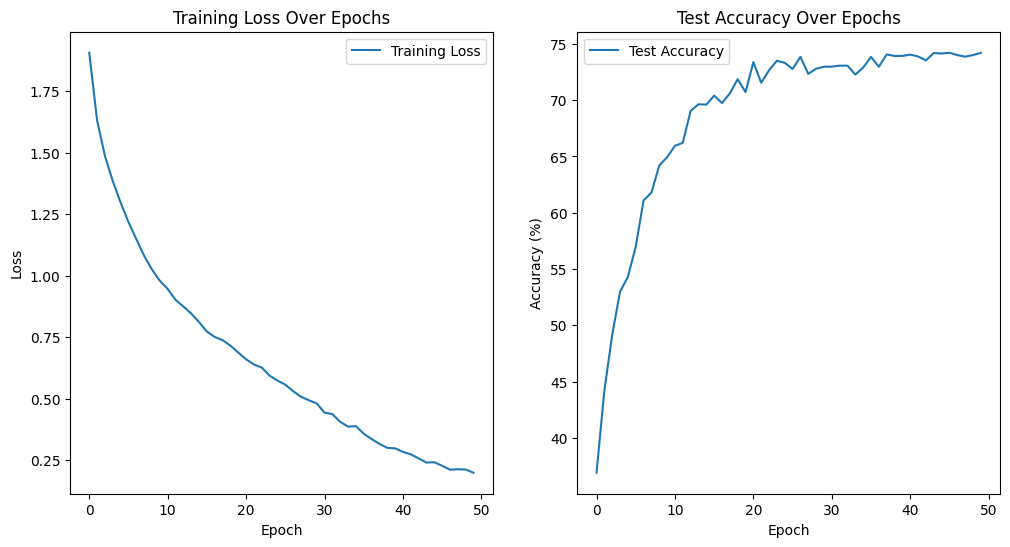

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# 5.0 Evaluate the Model

### 5.1 load the state dicts

In [ ]:
# Noted that I saved the state dicts with a incorrect model name,
# 'resnet18' represent 'VGG16' in this case.
student_model.load_state_dict(torch.load('./resnet18_deit_student.pth'))

<All keys matched successfully>

In [ ]:
student_model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = student_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_targets, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:\n', classification_report(all_targets, all_preds))

C:\Users\Chris\.conda\envs\torch_con\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  x = F.scaled_dot_product_attention(


Accuracy: 74.22%
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75       502
           1       0.80      0.85      0.82       523
           2       0.65      0.66      0.66       494
           3       0.61      0.57      0.59       498
           4       0.71      0.69      0.70       512
           5       0.68      0.67      0.68       469
           6       0.78      0.82      0.80       499
           7       0.78      0.77      0.77       487
           8       0.86      0.85      0.85       529
           9       0.81      0.76      0.79       487

    accuracy                           0.74      5000
   macro avg       0.74      0.74      0.74      5000
weighted avg       0.74      0.74      0.74      5000

